# Ranking Ads (multi-armed bandits)
** *
*Note: if you are visualizing this notebook directly from GitHub, some mathematical symbols might display incorrectly or not display at all. This same notebook can be rendered from nbviewer by following [this link.](http://nbviewer.ipython.org/github/david-cortes/datascienceprojects/blob/master/optimization/ranking_ads_multiarmed_bandits.ipynb)*

This project consists of comparing different policies for how to choose an ad to show amongst a large pool of ads in different situations, using only information about their historical clicks and impressions (that is, no features). The objective is, intuitively, to show the ads that would give the most clicks every time.

This is known as the multi-armed bandits problem, and the challenge is that, if an algorithm/policy is constantly showing new ads to see how well they do, it would get a low average click rate, whereas if it always shows the same ads, it might miss the fact that there are other, better ads to show (known as the exploration/exploitation dilemma).

Here I’ll compare different approaches by making simulations under different situations, assuming that each ad has an inherent probability of being clicked when shown (this probability is not known) and changing some of the conditions (e.g. equal vs. different payment per click, few vs. many, permanent vs. expiring, fixed vs. changing probabilities).
** *
## Sections

[1. Common algorithms](#p1)
* [1.1 Classical setting](#p11)
* [1.2 Different prices and multiple ads shown](#p12)

[2. Infinite pool of ads (many-armed bandits)](#p2)

[3. Changing click probabilities (restless bandits)](#p3)
* [3.1 Slowly changing probabilities](#p31)
* [3.2 Not-so-slowly changing probabilities](#p32)

[4. Expiring ads (mortal multi-armed bandits)](#p4)
** *

<a id="p1"></a>
## 1 Common algorithms
** *
The most successful and widely studied families of algorithms for this problem have consistently being those that create upper confidence bounds on the click probability of each ad based on observed clicks and impressions, and those that randomly or greedily alternate steps of exploitation (showing what has historically been the best ad) and exploration (showing a different ad).

In the most general setting of the multi-armed bandits problem, when the rewards of each arm (here: the click probabilities of each ad) can follow arbitrary distributions (e.g. not just click/no-click, but perhaps something more), upper bounds can be calculated using Hoeffdings inequality and decaying the probability of the sum of variables being less than something with time (e.g.$p=t^{-4}$) – giving the following formula at each time step $T$ for each ad $i$ (known as UCB1):

$$ Upper\: bound \:\hat{P_i} = \frac{\sum_t Clicks_{i,t}}{\sum_t Displays_{i,t}} + \sqrt{ \frac{2 \times ln \,T}{\sum_t Displays_{i,t}} }$$

However, as in this case the clicks are known to follow a Bernoulli distribution (i.e. we know that they can only be click or no-click, each with a certain probability), it's possible to build better upper confidence bounds using classical statistical approximations for the confidence interval of a rate.

Let $ \hat{P_i} = \frac{\sum_t Clicks_{i,t}}{\sum_t Displays_{i,t}}$ and $ Z_{inv}(x)$ be the z-score in a normal distribution at which $ P(\frac{X-\bar{X}}{\sigma} \ge Z) = x $, then:

$$ Confidence \: Interval \: (P_i, \alpha) = \hat{P_i} + Z_{inv}(\alpha) \times \sqrt{\frac{\hat{P_i}\times(1-\hat{P_i})}{\sum_t Displays_{i,t}}} $$

<center>_Note: this is an approximation only, but holds pretty well for large samples and non-extreme rates._</center>

Then, at each opportunity, the ad with the highest upper confidence bound on its estimated click rate is shown.

Under bayesian assumptions, a potential policy to follow is to establish prior distributions for the rates of each ad (such as a beta distribution given by a=clicks,b=impressions-clicks), sample each parameter randomly form their prior distributions, and show the ad with the highest such sampled parameter (known as Thompson sampling), then updating the priors.

In the family of randomized exploration/exploitation algorithms, algorithms known as _Epsilon-Greedy_ take at each step an exploration move (show a random ad) or exploitation move (show the ad with the highest historical click rate) with a certain probability.

Here I'll compare different instantiations (using different parameters) of these algorithms just described: UCB1, Upper Confidence Interval, Thompson Sampling, Epislon-Greedy.
** *
The performance of algorithms for the multi-armed bandits problem can studied and evaluated in terms of their _regret_ - that is, the difference between selecting, at each opportunity, the ad that had the highest click probability vs. the ad that the policy chooses, accummulated in time.

It can be proven mathematically that the regret of UCB algorithms and Thompson sampling can be upper bounded, as T tends to infinite, by $O(K ln T)$ (where K is the number of ads and T is the time), and it can be proved that no algorithm can achieve an asymptotically better bound than this (meaning: the accumulated regret of a good algorithm should only increase logarithmically with time - something that increases linearly (meaning: the ad selection criteria doesn't improve after collecting more clicks and impressions) would be bad).

However, this is only an asymptotic bound and in practice different algorithms with the same asymptotic bound can achieve quantitatively different results at any given non-infinite time.

** *
<a id="p11"></a>
### 1.1 Classical setting

In order to compare different ranking policies, I'll start with a simulation of the most studied formulation of this problem, given as follows:
* At each step or turn, one ad has to be selected to be shown from a pool of _n_ ads.
* Each ad has a given probability of being clicked when shown, which is constant through time.
* Every time an ad is shown, it’s known whether it was clicked or not, and this is the only information given about ads.
* Each click is equally good.

_(In the literature, the ads would be known as 'arms' - as in the arms of a one-armed bandit gambling machine - and the clicks received as rewards)_

Here I’ll simulate the environment as follows:
* Probabilities of ads being clicked as coming from a beta distribution ($P(Click_{ad}) \sim Beta(2,17)$)
* 100,000 time steps (i.e. 100,000 visits or impressions).
* When appropriate, algorithms start with an assumption (or prior distribution modeled as beta(1,1)) of each ad having a 50% click rate.

Which ad would have gotten a click at each time step will be decided at the beginning of each iteration, thus each algorithm will get the exact same environment (not just the same probabilities) and, should they make the same choices, they will get the exact same number of clicks.

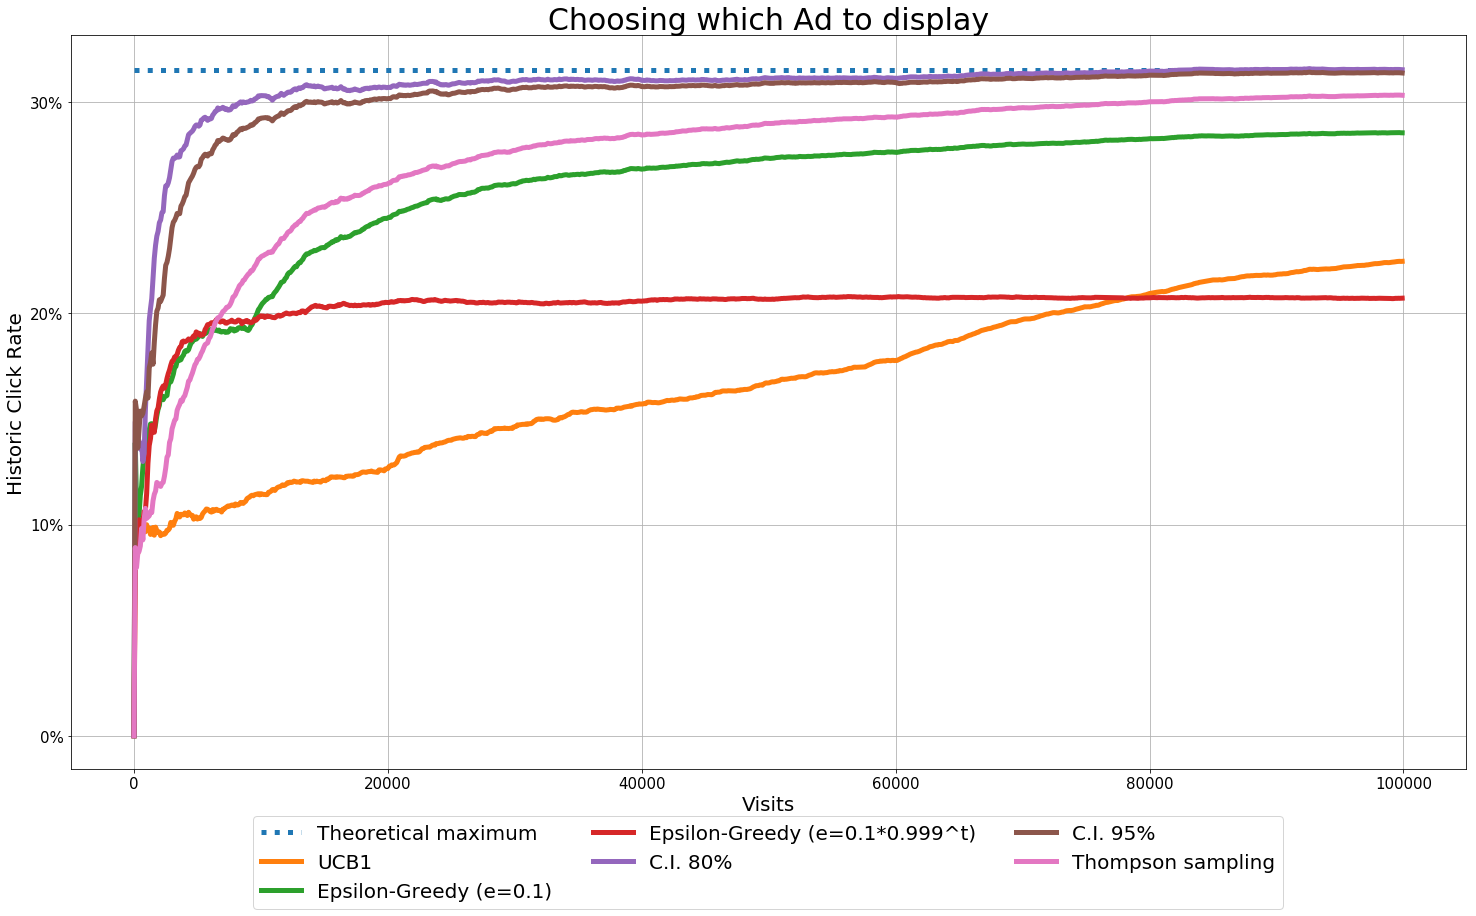

In [1]:
import numpy as np, matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

# 100 ads
n_ads=100
np.random.seed(159)
ads_clickprob=np.random.beta(2,17,size=n_ads)
max_ctr=np.max(ads_clickprob)

# counters keeping track of what each algorithm sees
clicks_eg1=np.array([1]*n_ads)
trials_eg1=np.array([2]*n_ads)
ctr_eg1=list()

clicks_eg_dec=np.array([1]*n_ads)
trials_eg_dec=np.array([2]*n_ads)
ctr_eg_dec=list()

clicks_ucb1=np.array([1]*n_ads)
trials_ucb1=np.array([2]*n_ads)
ctr_ucb1=list()

clicks_ci8=np.array([1]*n_ads)
trials_ci8=np.array([2]*n_ads)
ctr_ci8=list()

clicks_ci95=np.array([1]*n_ads)
trials_ci95=np.array([2]*n_ads)
ctr_ci95=list()

clicks_thomp=np.array([0]*n_ads)
trials_thomp=np.array([0]*n_ads)
ctr_thomp=list()

# initiating the simulation
np.random.seed(123)
for i in range(100000):
    if np.random.random()<=.1:
        ad_eg1=np.random.randint(low=0,high=n_ads)
    else:
        ad_eg1=np.argmax(clicks_eg1/trials_eg1)
    trials_eg1[ad_eg1]+=1
    
    if np.random.random()<=.1*(.999**i):
        ad_eg_dec=np.random.randint(low=0,high=n_ads)
    else:
        ad_eg_dec=np.argmax(clicks_eg_dec/trials_eg_dec)
    trials_eg_dec[ad_eg_dec]+=1
    
    ad_ucb1=np.argmax(clicks_ucb1/trials_ucb1 + np.sqrt(2*np.log(i+3))/np.sqrt(trials_ucb1))
    trials_ucb1[ad_ucb1]+=1
    
    rate_ci8=clicks_ci8/trials_ci8
    ad_ci8=np.argmax(rate_ci8 + 0.8*np.sqrt(rate_ci8*(1-rate_ci8)/trials_ci8))
    trials_ci8[ad_ci8]+=1
    
    rate_ci95=clicks_ci95/trials_ci95
    ad_ci95=np.argmax(rate_ci95 + 1.64*np.sqrt(rate_ci95*(1-rate_ci95)/trials_ci95))
    trials_ci95[ad_ci95]+=1
    
    ad_thompson=np.argmax([np.random.beta(clicks_thomp[a]+1,trials_thomp[a]-clicks_thomp[a]+1) for a in range(n_ads)])
    trials_thomp[ad_thompson]+=1
    
    # determining clicks
    would_have_clicked=[np.random.binomial(1,ads_clickprob[a]) for a in range(n_ads)]
    
    clicks_eg1[ad_eg1]+=would_have_clicked[ad_eg1]
    clicks_eg_dec[ad_eg_dec]+=would_have_clicked[ad_eg_dec]
    clicks_ucb1[ad_ucb1]+=would_have_clicked[ad_ucb1]
    clicks_ci8[ad_ci8]+=would_have_clicked[ad_ci8]
    clicks_ci95[ad_ci95]+=would_have_clicked[ad_ci95]
    clicks_thomp[ad_thompson]+=would_have_clicked[ad_thompson]
    
    # collecting CTR every 100 steps
    if (i%100)==0:
        ctr_eg1.append((np.sum(clicks_eg1)-1*n_ads)/(np.sum(trials_eg1)-2*n_ads))
        ctr_eg_dec.append((np.sum(clicks_eg_dec)-1*n_ads)/(np.sum(trials_eg_dec)-2*n_ads))
        ctr_ucb1.append((np.sum(clicks_ucb1)-1*n_ads)/(np.sum(trials_ucb1)-2*n_ads))
        ctr_ci8.append((np.sum(clicks_ci8)-1*n_ads)/(np.sum(trials_ci8)-2*n_ads))
        ctr_ci95.append((np.sum(clicks_ci95)-1*n_ads)/(np.sum(trials_ci95)-2*n_ads))
        ctr_thomp.append(np.sum(clicks_thomp)/np.sum(trials_thomp))

# visualizing teh results    
rcParams['figure.figsize'] = 25, 15
lwd=5
plt.plot([np.max(ads_clickprob)]*int((i+1)/100),linestyle=':',label='Theoretical maximum',linewidth=lwd)
plt.plot(ctr_ucb1,label='UCB1',linewidth=lwd)
plt.plot(ctr_eg1,label='Epsilon-Greedy (e=0.1)',linewidth=lwd)
plt.plot(ctr_eg_dec,label='Epsilon-Greedy (e=0.1*0.999^t)',linewidth=lwd)
plt.plot(ctr_ci8,label='C.I. 80%',linewidth=lwd)
plt.plot(ctr_ci95,label='C.I. 95%',linewidth=lwd)
plt.plot(ctr_thomp,label='Thompson sampling',linewidth=lwd)
plt.grid()


ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})

plt.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels([0]+[100*i for i in range(0,1000+200,200)])

ax.yaxis.set_ticks([i/10 for i in range(0,int(10*np.round(np.max(ads_clickprob),1))+1)])
ax.yaxis.set_ticklabels([str(i*10)+'%' for i in range(0,int(10*np.round(np.max(ads_clickprob),1))+1)])

plt.xlabel('Visits',size=20)
plt.ylabel('Historic Click Rate',size=20)
plt.title('Choosing which Ad to display',size=30)
plt.show()

_Here the Epsilon-Greedy with decaying explore probability didn't manage to explore enough and got stuck with an inferior ad. Also note that while the UCB, UCB throgh C.I. and Thompson sampling algorithms have the same asymptotic performance, there is a marked difference in their performance at any given non-infinite time._

<a id="p12"></a>
### 1.2 Different prices and multiple ads shown

The same algorithms can be easily extended to the case of multiple ads shown at each opporunity - say, selecting 5 ads to show instead of just 1 - and different rewards per ad (e.g. each ad pays a different ammount per click received, which is independent of its click-through rate), by selecting the ad with the highest expected upper bound of payoff, i.e. $argmax \: Revenue_{i} \times UCB(\hat{P_i}) $.

Only in the case of Epislon-Greedy algorithms, there is a bit of performance loss with respect to the UCB classes of algorithms, as they still randomly select ads regardless of their click value.

Here I'll simulate the same situation as before, but this time:
* Five ads are shown at each opportunity, and their click probabilities are independent of each other (perhaps not entirely reflective of internet advertising).
* Each ad has a price paid per click, which is simulated as a random variable from a gamma distribution.

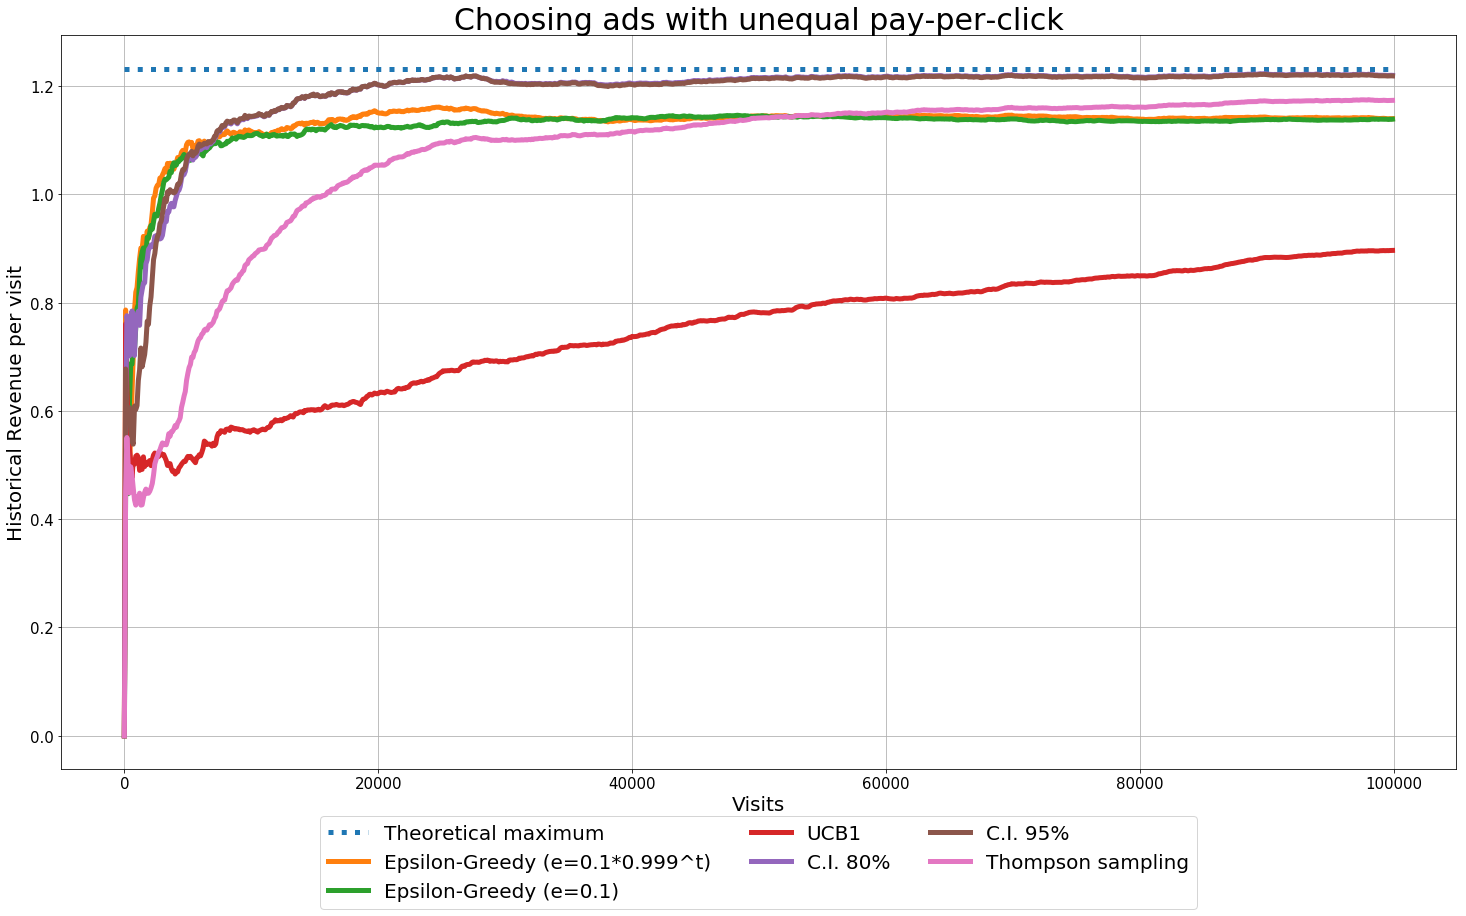

In [2]:
# similar simulation as before

# this time, ads have a price per click
n_ads=100
np.random.seed(159)
ads_clickprob=np.random.beta(2,17,size=n_ads)
ads_payment=np.random.gamma(20,.2,size=n_ads)
max_value=np.max(ads_clickprob*ads_payment)

clicks_eg1=np.array([1]*n_ads)
trials_eg1=np.array([2]*n_ads)
avg_rev_eg1=list()

clicks_eg_dec=np.array([1]*n_ads)
trials_eg_dec=np.array([2]*n_ads)
avg_rev_eg_dec=list()

clicks_ucb1=np.array([1]*n_ads)
trials_ucb1=np.array([2]*n_ads)
avg_rev_ucb1=list()

clicks_ci8=np.array([1]*n_ads)
trials_ci8=np.array([2]*n_ads)
avg_rev_ci8=list()

clicks_ci95=np.array([1]*n_ads)
trials_ci95=np.array([2]*n_ads)
avg_rev_ci95=list()

clicks_thomp=np.array([0]*n_ads)
trials_thomp=np.array([0]*n_ads)
avg_rev_thomp=list()

rev_eg1=0
rev_eg_dec=0
rev_ucb1=0
rev_ci8=0
rev_ci95=0
rev_thomp=0

np.random.seed(123)
for i in range(100000):
    if np.random.random()<=.1:
        ad_eg1=np.random.randint(low=0,high=n_ads)
    else:
        ad_eg1=np.argmax(ads_payment*clicks_eg1/trials_eg1)
    trials_eg1[ad_eg1]+=1
    
    if np.random.random()<=.1*(.999**i):
        ad_eg_dec=np.random.randint(low=0,high=n_ads)
    else:
        ad_eg_dec=np.argmax(ads_payment*clicks_eg_dec/trials_eg_dec)
    trials_eg_dec[ad_eg_dec]+=1
    
    ad_ucb1=np.argmax(ads_payment*(clicks_ucb1/trials_ucb1 + np.sqrt(2*np.log(i+3))/np.sqrt(trials_ucb1)))
    trials_ucb1[ad_ucb1]+=1
    
    rate_ci8=clicks_ci8/trials_ci8
    ad_ci8=np.argmax(ads_payment*(rate_ci8 + 0.8*np.sqrt(rate_ci8*(1-rate_ci8)/trials_ci8)))
    trials_ci8[ad_ci8]+=1
    
    rate_ci95=clicks_ci95/trials_ci95
    ad_ci95=np.argmax(ads_payment*(rate_ci95 + 1.64*np.sqrt(rate_ci95*(1-rate_ci95)/trials_ci95)))
    trials_ci95[ad_ci95]+=1
    
    ad_thompson=np.argmax(ads_payment*np.array([np.random.beta(clicks_thomp[a]+1,trials_thomp[a]-clicks_thomp[a]+1) for a in range(n_ads)]))
    trials_thomp[ad_thompson]+=1
    
    # determining clicks
    would_have_clicked=[np.random.binomial(1,ads_clickprob[a]) for a in range(n_ads)]
    
    clicks_eg1[ad_eg1]+=would_have_clicked[ad_eg1]
    clicks_eg_dec[ad_eg_dec]+=would_have_clicked[ad_eg_dec]
    clicks_ucb1[ad_ucb1]+=would_have_clicked[ad_ucb1]
    clicks_ci8[ad_ci8]+=would_have_clicked[ad_ci8]
    clicks_ci95[ad_ci95]+=would_have_clicked[ad_ci95]
    clicks_thomp[ad_thompson]+=would_have_clicked[ad_thompson]
    
    rev_eg1+=would_have_clicked[ad_eg1]*ads_payment[ad_eg1]
    rev_eg_dec+=would_have_clicked[ad_eg_dec]*ads_payment[ad_eg_dec]
    rev_ucb1+=would_have_clicked[ad_ucb1]*ads_payment[ad_ucb1]
    rev_ci8+=would_have_clicked[ad_ci8]*ads_payment[ad_ci8]
    rev_ci95+=would_have_clicked[ad_ci95]*ads_payment[ad_ci95]
    rev_thomp+=would_have_clicked[ad_thompson]*ads_payment[ad_thompson]
    
    if (i%100)==0:
        avg_rev_eg1.append(rev_eg1/(i+1))
        avg_rev_eg_dec.append(rev_eg_dec/(i+1))
        avg_rev_ucb1.append(rev_ucb1/(i+1))
        avg_rev_ci8.append(rev_ci8/(i+1))
        avg_rev_ci95.append(rev_ci95/(i+1))
        avg_rev_thomp.append(rev_thomp/(i+1))

        
rcParams['figure.figsize'] = 25, 15
lwd=5
plt.plot([max_value]*int((i+1)/100),linestyle=':',label='Theoretical maximum',linewidth=lwd)
plt.plot(avg_rev_eg1,label='Epsilon-Greedy (e=0.1*0.999^t)',linewidth=lwd)
plt.plot(avg_rev_eg_dec,label='Epsilon-Greedy (e=0.1)',linewidth=lwd)
plt.plot(avg_rev_ucb1,label='UCB1',linewidth=lwd)
plt.plot(avg_rev_ci8,label='C.I. 80%',linewidth=lwd)
plt.plot(avg_rev_ci95,label='C.I. 95%',linewidth=lwd)
plt.plot(avg_rev_thomp,label='Thompson sampling',linewidth=lwd)
plt.grid()


ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})

plt.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels([0]+[100*i for i in range(0,1000+200,200)])

plt.xlabel('Visits',size=20)
plt.ylabel('Historical Revenue per visit',size=20)
plt.title('Choosing ads with unequal pay-per-click',size=30)
plt.show()

_As expected, nothing changed much with respect to the previous situation._

<a id="p2"></a>
## 2. Infinite pool of ads (many-armed bandits)
** *
Algorithms based on upper-confidence bounds start by exploring all the different ads, thus if there are an infinite number of ads, or a number of ads larger than the number of times that an ad will be shown, their performance is the same as just selecting an ad at random.

In such settings (known as _many-armed bandits_), algorithms based on trying one ad at a time and switching to a new ad based on numbers of consecutive failures for a certain number of times can have a provable sub-linear asymptotic bound on their regret, as described in [Berry, D. A., Chen, R. W., Zame, A., Heath, D. C., & Shepp, L. A. (1997). Bandit problems with infinitely many arms. The Annals of Statistics, 2103-2116.](http://www.jstor.org/stable/2959020), [Herschkorn, S. J., Pekoez, E., & Ross, S. M. (1996). Policies without memory for the infinite-armed Bernoulli bandit under the average-reward criterion. Probability in the Engineering and Informational Sciences, 10, 21-28.](http://people.bu.edu/pekoz/bbandit.pdf) and [Teytaud, O., Gelly, S., & Sebag, M. (2007). Anytime many-armed bandits. In CAP07.](https://hal.inria.fr/inria-00173263/), if the number of time steps/iterations/visits is known an the number of failures is established according to it.

While not having a mathematically provable bound on their regret, other families of greedy algorithms can in practice have even better performance than failure-based algorithms, such as those based on dropping an ad if its empirical performance falls below some threshold (_alpha-rate_), or other greedy algorithms based on exploring/exploiting according to the empirical performance of the best ad – here I’ll also compare the _Adaptive Greedy_ algorithm as described in [Chakrabarti, D., Kumar, R., Radlinski, F., & Upfal, E. (2009). Mortal multi-armed bandits. In Advances in neural information processing systems (pp. 273-280).]( http://papers.nips.cc/paper/3580-mortal-multi-armed-bandits), with the slight modification of, in exploration steps, choosing with a certain probability between taking a new ad or showing an old ad.

Even within the upper confidence bound family of algorithms, variations of them that explore only a subset of the possibilities at a time can achieve a low regret, depending on the underlying distribution of probabilities of each ad (reward distribution of each arm). As well, greedy algorothms based on exploiting old ads or taking new ads can also perform well in practice.
** *
Here I’ll simulate such a situation by having as many ads as time steps to show one of them. This is, in practice, the same as having an infinite pool of ads, if we considering that any ad is the same before being selected to be shown. However, as they will already be instantiated in the simulation, it’s still possible to calculate the regret with respect to the best ad rather than with the maximum probability of the distribution from which the click probabilities of each ad are shown (in a beta distribution, that would be a probability of 1).

This time the simulation is with object-oriented programming, with each algorithm taking a new ad from a pool of ads that shows them in the exact same order for all, and as well, the clicks that each ad would have received determined at the beginning of each iteration and being the same for all ads.


In [3]:
class manyarmed_bandit:
    def __init__(self,ordered_clickprob):
        self.ads_taken=-1
        self.clicks=np.array([])
        self.displays=np.array([])
        
        # for failure-based methods
        self.m=10
        self.k_failures=1
        self.chosen_m=None
        
        # for alpha-rate
        self.alpha=0.4
        
        # for adaptive greedy
        self.greedy_c=2
        
    # parameters
    def set_m(self,m):
        self.m=m
        
    def set_k_failures(self,k):
        self.k_failures=k
        
    def set_alpha(self,alpha):
        self.alpha=alpha
        
    def set_greedy_c(self,c):
        self.greedy_c=c
        
    # some universal features
    def take_new(self):
        self.clicks=np.concatenate([self.clicks,[0]])
        self.displays=np.concatenate([self.displays,[0]])
        self.ads_taken+=1
        
    def get_ctr(self):
        return np.sum(self.clicks)/np.sum(self.displays)
        
    def show_ad(self,selected_ad,would_have_clicked):
        self.displays[selected_ad]+=1
        self.clicks[selected_ad]+=would_have_clicked[selected_ad]
        
    def show_last(self,would_have_clicked):
        self.clicks[self.ads_taken]+=would_have_clicked[self.ads_taken]
        self.displays[self.ads_taken]+=1
        
    def show_best_ad(self,would_have_clicked):
        best_ad=np.nanargmax(self.clicks/self.displays)
        self.show_ad(best_ad,would_have_clicked)
    
    def show_best_bi_ci(self,would_have_clicked):
        if np.sum(self.displays)>0:
            ctr=self.clicks/self.displays
            best_ad=np.nanargmax(ctr + 0.8*np.sqrt(ctr*(1-ctr)/self.displays))
            self.show_ad(best_ad,would_have_clicked)
        else:
            self.take_new()
            self.show_last(would_have_clicked)
        
    def show_random_ad(self,would_have_clicked):
        self.show_ad(np.random.randint(low=0,high=self.clicks.shape[0]),would_have_clicked)
        
    # adaptive greedy
    def show_ad_adaptive_greedy_split_newold(self,would_have_clicked,p_new=.5):
        if np.sum(self.clicks)==0:
            self.show_random_ad(would_have_clicked)
        else:
            bestr=np.nanmax(self.clicks/self.displays)
            if np.random.random()<self.greedy_c*bestr:
                self.show_best_ad(would_have_clicked)
            else:
                if np.random.random()<p_new:
                    # choose a random ad
                    self.take_new()
                    self.show_last(would_have_clicked)
                else:
                    # choose an old random ad
                    self.show_random_ad(would_have_clicked)
                 
    # failure-based
    def show_ad_k_failures(self,would_have_clicked):
        if (self.displays[-1]-self.clicks[-1])>=self.k_failures:
            self.take_new()
        self.show_last(would_have_clicked)
        
    def show_ad_m_run_nonrecalling(self,would_have_clicked):
        if self.chosen_m is not None:
            self.show_ad(self.chosen_m,would_have_clicked)
        else:
            self.show_ad_k_failures(would_have_clicked)
            if (self.clicks[-1]>=self.m) and ((self.displays[-1]-self.clicks[-1])==0):
                self.chosen_m=self.clicks.shape[0]-1
                
    def show_ad_m_run(self,would_have_clicked):
        if self.chosen_m is not None:
            self.show_ad(self.chosen_m,would_have_clicked)
        else:
            self.show_ad_k_failures(would_have_clicked)
            if (self.clicks[-1]>=self.m) and ((self.displays[-1]-self.clicks[-1])==0):
                self.chosen_m=np.nanargmax(self.clicks/self.displays)
            if self.displays.shape[0]>=self.m:
                self.chosen_m=np.nanargmax(self.clicks/self.displays)
    
    # other heuristics
    def show_best_by_ci_greedy(self,would_have_clicked,p_new=.5):
        if np.random.random()<p_new:
            self.take_new()
            self.show_last(would_have_clicked)
        else:
            self.show_best_bi_ci(would_have_clicked)
            
    def show_best_by_alpha_rate(self,would_have_clicked):
        if (self.clicks[-1]/self.displays[-1])>=self.alpha:
            self.show_last(would_have_clicked)
        else:
            self.take_new()
            self.show_last(would_have_clicked)

In [4]:
# simulation's underlying parameters
generator_par_a=2
generator_par_b=10

# initial arms
n_ads=20000
ads_clickprob=list(np.random.beta(generator_par_a,generator_par_b,size=n_ads))

bandits_adaptive_greedy=manyarmed_bandit(ads_clickprob)
bandits_adaptive_greedy.take_new()
ctr_adaptive_greedy=list()

bandits_1_failures=manyarmed_bandit(ads_clickprob)
bandits_1_failures.take_new()
ctr_1_failures=list()

bandits_4_failures=manyarmed_bandit(ads_clickprob)
bandits_4_failures.set_k_failures(4)
bandits_4_failures.take_new()
ctr_4_failures=list()

bandits_m_run_nonrecalling_low_m=manyarmed_bandit(ads_clickprob)
bandits_m_run_nonrecalling_low_m.set_m(100)
bandits_m_run_nonrecalling_low_m.take_new()
ctr_m_run_nonrecalling_low_m=list()

bandits_m_run_low_m=manyarmed_bandit(ads_clickprob)
bandits_m_run_low_m.set_m(100)
bandits_m_run_low_m.take_new()
ctr_m_run_low_m=list()

bandits_m_run_nonrecalling=manyarmed_bandit(ads_clickprob)
bandits_m_run_nonrecalling.set_m(np.sqrt(n_ads))
bandits_m_run_nonrecalling.take_new()
ctr_m_run_nonrecalling=list()

bandits_m_run=manyarmed_bandit(ads_clickprob)
bandits_m_run.set_m(np.sqrt(n_ads))
bandits_m_run.take_new()
ctr_m_run=list()


bandits_ci_greedy=manyarmed_bandit(ads_clickprob)
bandits_ci_greedy.take_new()
ctr_ci_greedy=list()

bandits_ci_greedy_decreasing=manyarmed_bandit(ads_clickprob)
bandits_ci_greedy_decreasing.take_new()
ctr_ci_greedy_decreasing=list()

bandits_alpha_rate=manyarmed_bandit(ads_clickprob)
bandits_alpha_rate.take_new()
ctr_alpha_rate=list()

bandits_alpha_rate2=manyarmed_bandit(ads_clickprob)
bandits_alpha_rate2.set_alpha(.65)
bandits_alpha_rate2.take_new()
ctr_alpha_rate2=list()

np.random.seed(777)
for i in range(n_ads):
    # algorithms take ads sequentially, thus at each time step there's only a limited number they can have already taken
    would_have_clicked=[np.random.binomial(1,ads_clickprob[ad_prob]) for ad_prob in range(min(i+2,n_ads))]

    
    ######################
    bandits_adaptive_greedy.show_ad_adaptive_greedy_split_newold(would_have_clicked,p_new=.5)
    bandits_1_failures.show_ad_k_failures(would_have_clicked)
    bandits_4_failures.show_ad_k_failures(would_have_clicked)
    bandits_m_run_nonrecalling_low_m.show_ad_m_run_nonrecalling(would_have_clicked)
    bandits_m_run_low_m.show_ad_m_run(would_have_clicked)
    bandits_m_run_nonrecalling.show_ad_m_run_nonrecalling(would_have_clicked)
    bandits_m_run.show_ad_m_run(would_have_clicked)
    bandits_ci_greedy.show_best_by_ci_greedy(would_have_clicked,p_new=.25)
    bandits_ci_greedy_decreasing.show_best_by_ci_greedy(would_have_clicked,p_new=1.0*(.999**i))
    bandits_alpha_rate.show_best_by_alpha_rate(would_have_clicked)
    bandits_alpha_rate2.show_best_by_alpha_rate(would_have_clicked)
    
    
    ######################
    if (i%100)==0:
        ctr_adaptive_greedy.append(bandits_adaptive_greedy.get_ctr())
        ctr_1_failures.append(bandits_1_failures.get_ctr())
        ctr_4_failures.append(bandits_4_failures.get_ctr())
        ctr_m_run_nonrecalling_low_m.append(bandits_m_run_nonrecalling_low_m.get_ctr())
        ctr_m_run_low_m.append(bandits_m_run_low_m.get_ctr())
        ctr_m_run_nonrecalling.append(bandits_m_run_nonrecalling.get_ctr())
        ctr_m_run.append(bandits_m_run.get_ctr())
        ctr_ci_greedy.append(bandits_ci_greedy.get_ctr())
        ctr_ci_greedy_decreasing.append(bandits_ci_greedy_decreasing.get_ctr())
        ctr_alpha_rate.append(bandits_alpha_rate.get_ctr())
        ctr_alpha_rate2.append(bandits_alpha_rate2.get_ctr())

C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:114: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:54: RuntimeWarning: invalid value encountered in true_divide


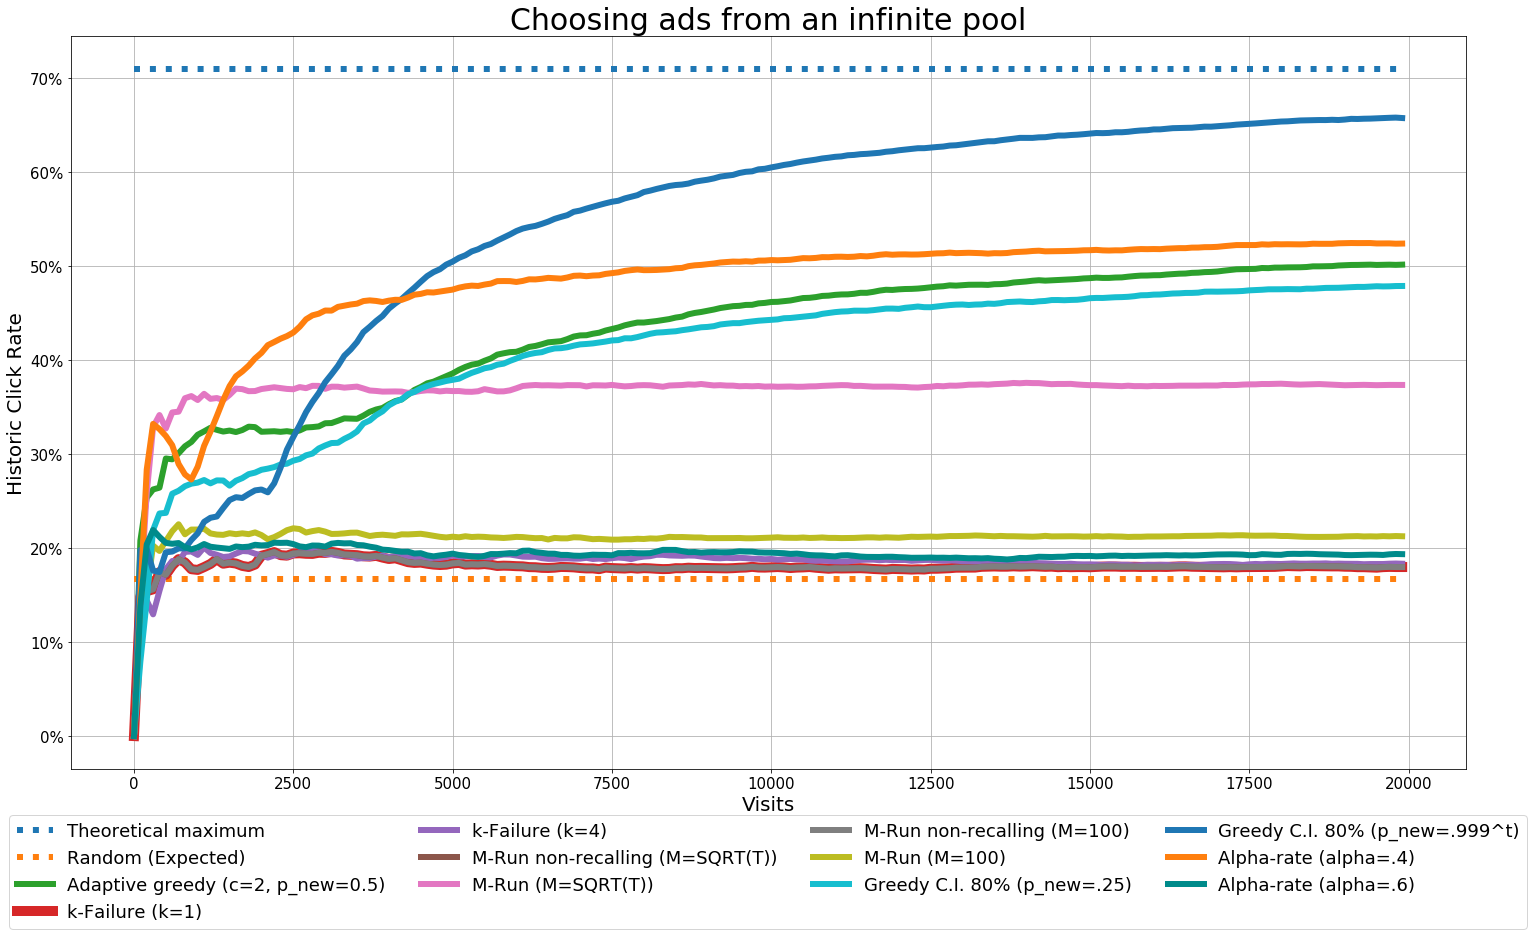

In [5]:
from pylab import rcParams

rcParams['figure.figsize'] = 25, 15

start_from=0
lwd=6
plt.plot(([np.max(ads_clickprob)]*len(ctr_1_failures))[start_from:],label='Theoretical maximum',linestyle=':',linewidth=lwd)
plt.plot(([np.mean(ads_clickprob)]*len(ctr_1_failures))[start_from:],label='Random (Expected)',linestyle=':',linewidth=lwd)

plt.plot(ctr_adaptive_greedy[start_from:],label='Adaptive greedy (c=2, p_new=0.5)',linewidth=lwd)
plt.plot(ctr_1_failures[start_from:],label='k-Failure (k=1)',linewidth=10)
plt.plot(ctr_4_failures[start_from:],label='k-Failure (k=4)',linewidth=lwd)
plt.plot(ctr_m_run_nonrecalling_low_m[start_from:],label='M-Run non-recalling (M=SQRT(T))',linewidth=lwd)
plt.plot(ctr_m_run_low_m[start_from:],label='M-Run (M=SQRT(T))',linewidth=lwd)
plt.plot(ctr_m_run_nonrecalling[start_from:],label='M-Run non-recalling (M=100)',linewidth=lwd)
plt.plot(ctr_m_run[start_from:],label='M-Run (M=100)',linewidth=lwd)
plt.plot(ctr_ci_greedy[start_from:],label='Greedy C.I. 80% (p_new=.25)',linewidth=lwd)
plt.plot(ctr_ci_greedy_decreasing[start_from:],label='Greedy C.I. 80% (p_new=.999^t)',linewidth=lwd)
plt.plot(ctr_alpha_rate[start_from:],label='Alpha-rate (alpha=.4)',linewidth=lwd)
plt.plot(ctr_alpha_rate2[start_from:],label='Alpha-rate (alpha=.6)',linewidth=lwd,color='darkcyan')
plt.grid()

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=4, prop={'size':18})

plt.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels([0]+[100*i for i in range(0,225,25)])

ax.yaxis.set_ticks([i/10 for i in range(0,int(10*np.round(np.max(ads_clickprob),1))+1)])
ax.yaxis.set_ticklabels([str(i*10)+'%' for i in range(0,int(10*np.round(np.max(ads_clickprob),1))+1)])

plt.xlabel('Visits',size=20)
plt.ylabel('Historic Click Rate',size=20)
plt.title('Choosing ads from an infinite pool',size=30)
plt.show()

<a id="p3"></a>
## 3. Changing click probabilities (restless bandits)
** *
All the previous settings assumed that the click probabilities of each ad (the reward distributions of each arm) are static. In practice, however, trends and tastes are constantly changing and the click probabilities of ads can change in the long run.

This problem is known as _restless bandits_ and variations of it under different settings have been studied in other contexts, such as when the clicks are not random but deterministically chosen by an all-powerful adversary in a mini-max context ([Auer, P., Cesa-Bianchi, N., Freund, Y., & Schapire, R. E. (2002). The nonstochastic multiarmed bandit problem. SIAM journal on computing, 32(1), 48-77.](http://epubs.siam.org/doi/abs/10.1137/S0097539701398375) – even under such conditions it’s still possible to achieve a sub-linear asymptotic regret), when the click probabilities might change abruptly at some point in time ([Hartland, C., Gelly, S., Baskiotis, N., Teytaud, O., & Sebag, M. (2006). Multi-armed bandit, dynamic environments and meta-bandits.](https://hal.inria.fr/hal-00113668/)), or when there is a small number of ads and their probabilities change according to a Wiener process with bound reflections ([Slivkins, A., & Upfal, E. (2008). Adapting to a Changing Environment: the Brownian Restless Bandits. In COLT (pp. 343-354).](http://slivkins.com/work/colt08.pdf) – their methods, however, don’t apply in cases where the number of ads is large).

Here I’ll simulate such a situation by having a score associated to each ad that translates into a click probability by a sigmoid function (defined below), and this score experiencing changes through a random walk, with a different variance for each ad (this is very similar to having log-odds that change through a random walk/Wiener process/Brownian motion, but with a more limited range of click probabilities). Unfortunately, such a setting has not been studied in the literature in the case of a large pool of ads.
** *
If the click probabilities change more slowly than the confidence intervals that UCB algorithms can generate, such algorithms can still achieve near-optimal regret as they are.

In cases of fast-changing probabilities, the same algorithms illustrated at the beginning can also be used if their past memory of clicks and impressions is reset after some iterations (as described too in ([Slivkins, A., & Upfal, E. (2008). Adapting to a Changing Environment: the Brownian Restless Bandits. In COLT (pp. 343-354).](http://slivkins.com/work/colt08.pdf)), or if they explore only a subset of ads at a time and this subset changes in time.

While not possible to estimate the volatility or variance of each ad probability, it’s possible to have an incorrect approximation even if the function that translates a 'score' into click probability is unknown, considering the last estimated click rate of each ad and the last time it was shown, by assuming that the log-odds of the adds follow some random walk with some pre-defined variance (this is, of course, incorrect, but can nevertheless help to determine when it’s time to try an old ad again, in the hopes that its click probability has increased enough).
** *
Coding the algorithms and necessary formulas - note that the objects defined here have methods with the same names as before, but they work differently:

In [6]:
def score_to_prob(score):
    return .6/(1+np.exp(-.25*(score-.25)))

def logodds_to_prob(logodds):
    return np.exp(logodds)/(1+np.exp(logodds))

def prob_to_logodds(prob):
    return np.log(prob/(1-prob))

In [7]:
class restless_bandit_model:
    def __init__(self,n_ads):
        self.n_ads=n_ads
        self.clicks=np.array([0]*n_ads)
        self.displays=np.array([0]*n_ads)
        self.last_shown=np.array([0]*n_ads)
        
        self.acc_clicks=0
        self.acc_displays=0
        
        self.k_chosen=set()
        self.k=0
        
        self.greedy_c=2
        
        self.last_random=None
        self.failures_in_a_row=0
        self.m=4
        
        self.est_volatility=.02
        
    def reset(self):
        self.acc_clicks+=np.sum(self.clicks)
        self.acc_displays+=np.sum(self.displays)
        
        self.clicks=np.array([0]*self.n_ads)
        self.displays=np.array([0]*self.n_ads)
        self.last_shown=np.array([0]*self.n_ads)
        
        self.k_chosen=set()
        
        self.last_random=None
        self.failures_in_a_row=0
        
    def show_ad(self,selected_ad,would_have_clicked,t):
        self.displays[selected_ad]+=1
        self.clicks[selected_ad]+=would_have_clicked[selected_ad]
        self.last_shown[selected_ad]=t
        self.failures_in_a_row+=1-would_have_clicked[selected_ad]
        
    def show_best_ad(self,would_have_clicked,t):
        best=np.nanargmax(self.clicks/self.displays)
        self.show_ad(best,would_have_clicked,t)
        
    def get_best_r(self):
        return np.nanmax(self.clicks/self.displays)
        
    def get_ctr(self):
        return (np.sum(self.clicks)+self.acc_clicks)/(np.sum(self.displays)+self.acc_displays)
    
    def choose_k(self,k):
        self.k_chosen=set(np.random.choice([i for i in range(self.clicks.shape[0])],size=k,replace=False))
        self.k=k
        
    def show_best_by_ci(self,would_have_clicked,t):
        rates=self.clicks/self.displays
        ad_ci=np.argmax(rates+0.8*np.sqrt(rates*(1-rates)/self.displays))
        self.show_ad(ad_ci,would_have_clicked,t)
        
    def show_best_by_ci_within_k(self,would_have_clicked,t):      
        rates=self.clicks/self.displays
        ci=rates+0.8*np.sqrt(rates*(1-rates)/self.displays)
        ci[[i for i in range(self.clicks.shape[0]) if i not in self.k_chosen]]=-1
        self.show_ad(np.argmax(ci),would_have_clicked,t)
        
    def show_ad_adaptive_greedy(self,would_have_clicked,t):
        if np.sum(self.clicks)==0:
            self.show_ad(np.random.randint(low=0,high=self.n_ads),would_have_clicked,t)
        else:
            bestr=self.get_best_r()
            if np.random.random()<self.greedy_c*bestr:
                self.show_best_ad(would_have_clicked,t)
            else:
                self.show_ad(np.random.randint(low=0,high=self.n_ads),would_have_clicked,t)
                
    def show_ad_m_failures_in_a_row(self,would_have_clicked,t):
        if self.last_random is None:
            self.last_random=np.random.randint(low=0,high=self.n_ads)
            self.failures_in_a_row=0
        if self.failures_in_a_row>=self.m:
            self.last_random=np.random.randint(low=0,high=self.n_ads)
            self.failures_in_a_row=0
            self.show_ad(self.last_random,would_have_clicked,t)
        else:
            self.show_ad(self.last_random,would_have_clicked,t)
            
    def show_best_by_ci_plus_extravar(self,would_have_clicked,t):
        rates=self.clicks/self.displays
        est_logodds=np.array([prob_to_logodds(r) for r in rates])
        diff_lastshown=t-self.last_shown
        
        extravar=est_logodds+0.8*np.sqrt(diff_lastshown*self.est_volatility)
        p_w_extravar=np.array([logodds_to_prob(lpr) for lpr in extravar])
        
        extra_ci=p_w_extravar+0.8*np.sqrt(rates*(1-rates)/self.displays)
        
        self.show_ad(np.argmax(extra_ci),would_have_clicked,t)

<a id="p31"></a>
### 3.1 Slowly changing probabilities
** *
First a simulation having probabilities that change slowly - if they change slowly enough, UCB-based algorithms don't suffer much in their performance.

In [8]:
np.random.seed(6534)

# generating parameters
n_ads=100
ads_probscores=-3.0+np.random.normal(loc=0,scale=4,size=n_ads)
ads_volatility=np.random.gamma(2,scale=.02,size=n_ads)

# generative process
def get_who_would_click():
    global ads_probscores,ads_volatility,ads_clickprob
    
    ads_probscores+=np.array([np.random.normal(loc=0,scale=vol) for vol in ads_volatility])
    ads_clickprob=[score_to_prob(s) for s in ads_probscores]
    would_have_clicked=[np.random.binomial(1,p) for p in ads_clickprob]
    return would_have_clicked

# models
ci_w_restarts=restless_bandit_model(n_ads)
ctr_ci_w_restarts=list()

ci_w_restarts2=restless_bandit_model(n_ads)
ctr_ci_w_restarts2=list()

ci_no_restart=restless_bandit_model(n_ads)
ctr_ci_no_restart=list()

ci_plus_extravar=restless_bandit_model(n_ads)
ci_plus_extravar.est_volatility=0.001
ctr_ci_plus_extravar=list()

ci_over_k=restless_bandit_model(n_ads)
ci_over_k.choose_k(30)
ctr_ci_over_k=list()

ci_over_k_w_restarts=restless_bandit_model(n_ads)
ci_over_k_w_restarts.choose_k(30)
ctr_ci_over_k_w_restarts=list()

m_failures=restless_bandit_model(n_ads)
m_failures.m=4
ctr_m_failures=list()

adaptive_greedy=restless_bandit_model(n_ads)
ctr_adaptive_greedy=list()


prob_max=list()
prob_avg=list()
ctr_max=list()
ctr_avg=list()

for t in range(20000):
    would_have_clicked=get_who_would_click()
    prob_max.append(np.max(ads_clickprob))
    prob_avg.append(np.mean(ads_clickprob))
    #############################
    
    ci_w_restarts.show_best_by_ci(would_have_clicked,t)
    ci_w_restarts2.show_best_by_ci(would_have_clicked,t)
    ci_no_restart.show_best_by_ci(would_have_clicked,t)
    ci_plus_extravar.show_best_by_ci_plus_extravar(would_have_clicked,t)
    ci_over_k.show_best_by_ci_within_k(would_have_clicked,t)
    ci_over_k_w_restarts.show_best_by_ci_within_k(would_have_clicked,t)
    m_failures.show_ad_m_failures_in_a_row(would_have_clicked,t)
    adaptive_greedy.show_ad_adaptive_greedy(would_have_clicked,t)
    
    
    if (t%500)==0 and t>0:
        ci_over_k.choose_k(30)
    
    if (t%1000)==0 and t>0:
        ci_w_restarts.reset()
        ci_over_k_w_restarts.reset()
        ci_over_k_w_restarts.choose_k(30)
        ci_w_restarts2.reset()
    
    #############################
    if (t%100)==0:
        ctr_max.append(np.mean(prob_max))
        ctr_avg.append(np.mean(prob_avg))

        ctr_ci_w_restarts.append(ci_w_restarts.get_ctr())
        ctr_ci_w_restarts2.append(ci_w_restarts2.get_ctr())
        ctr_ci_no_restart.append(ci_no_restart.get_ctr())
        ctr_ci_plus_extravar.append(ci_plus_extravar.get_ctr())
        ctr_ci_over_k.append(ci_over_k.get_ctr())
        ctr_ci_over_k_w_restarts.append(ci_over_k_w_restarts.get_ctr())
        ctr_m_failures.append(m_failures.get_ctr())
        ctr_adaptive_greedy.append(adaptive_greedy.get_ctr())

C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in double_sca

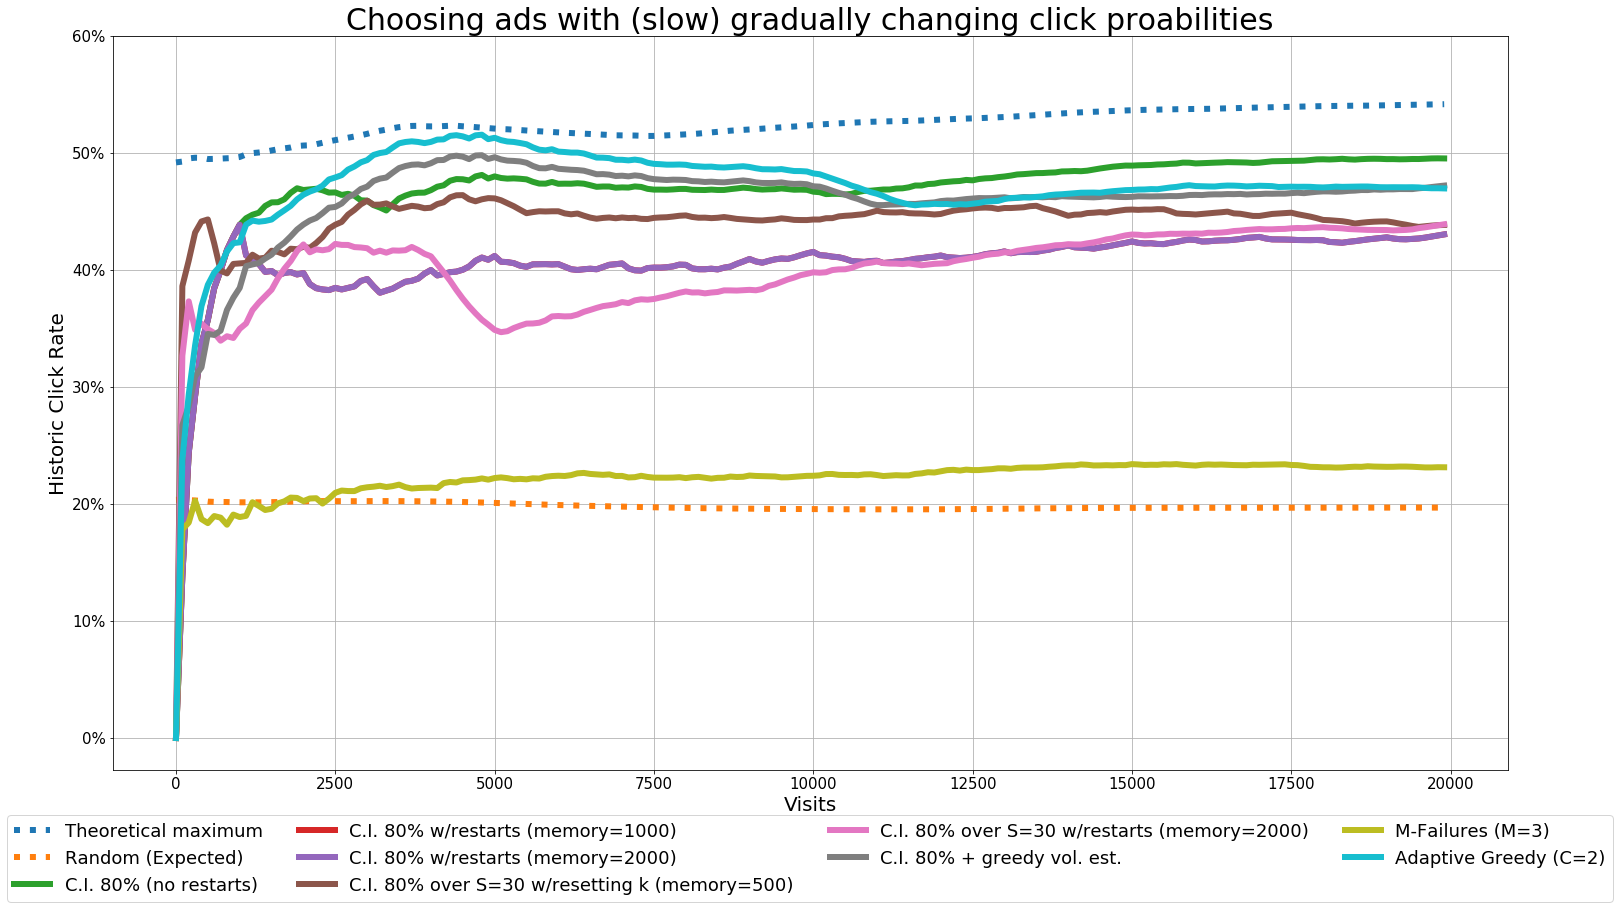

In [9]:
rcParams['figure.figsize'] = 25, 15

start_from=0
lwd=6
plt.plot(ctr_max[start_from:],label='Theoretical maximum',linestyle=':',linewidth=lwd)
plt.plot(ctr_avg[start_from:],label='Random (Expected)',linestyle=':',linewidth=lwd)

plt.plot(ctr_ci_no_restart[start_from:],label='C.I. 80% (no restarts)',linewidth=lwd)
plt.plot(ctr_ci_w_restarts[start_from:],label='C.I. 80% w/restarts (memory=1000)',linewidth=lwd)
plt.plot(ctr_ci_w_restarts2[start_from:],label='C.I. 80% w/restarts (memory=2000)',linewidth=lwd)
plt.plot(ctr_ci_over_k[start_from:],label='C.I. 80% over S=30 w/resetting k (memory=500)',linewidth=lwd)
plt.plot(ctr_ci_over_k_w_restarts[start_from:],label='C.I. 80% over S=30 w/restarts (memory=2000)',linewidth=lwd)
plt.plot(ctr_ci_plus_extravar[start_from:],label='C.I. 80% + greedy vol. est.',linewidth=lwd)
plt.plot(ctr_m_failures[start_from:],label='M-Failures (M=3)',linewidth=lwd)
plt.plot(ctr_adaptive_greedy[start_from:],label='Adaptive Greedy (C=2)',linewidth=lwd)
plt.grid()

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=4, prop={'size':18})

plt.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels([0]+[100*i for i in range(0,225,25)])

ax.yaxis.set_ticks([i/10 for i in range(0,int(10*np.round(np.max(ads_clickprob),1))+1)])
ax.yaxis.set_ticklabels([str(i*10)+'%' for i in range(0,int(10*np.round(np.max(ads_clickprob),1))+1)])

plt.xlabel('Visits',size=20)
plt.ylabel('Historic Click Rate',size=20)
plt.title('Choosing ads with (slow) gradually changing click proabilities',size=30)
plt.show()

<a id="p32"></a>
### 3.2 Not-so-slowly changing probabilities
** *
If, however, the click probabilities change faster, then other greedy algorithms can outperform simple upper confidence bounds that assume probabilites to be static:

C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in double_sca

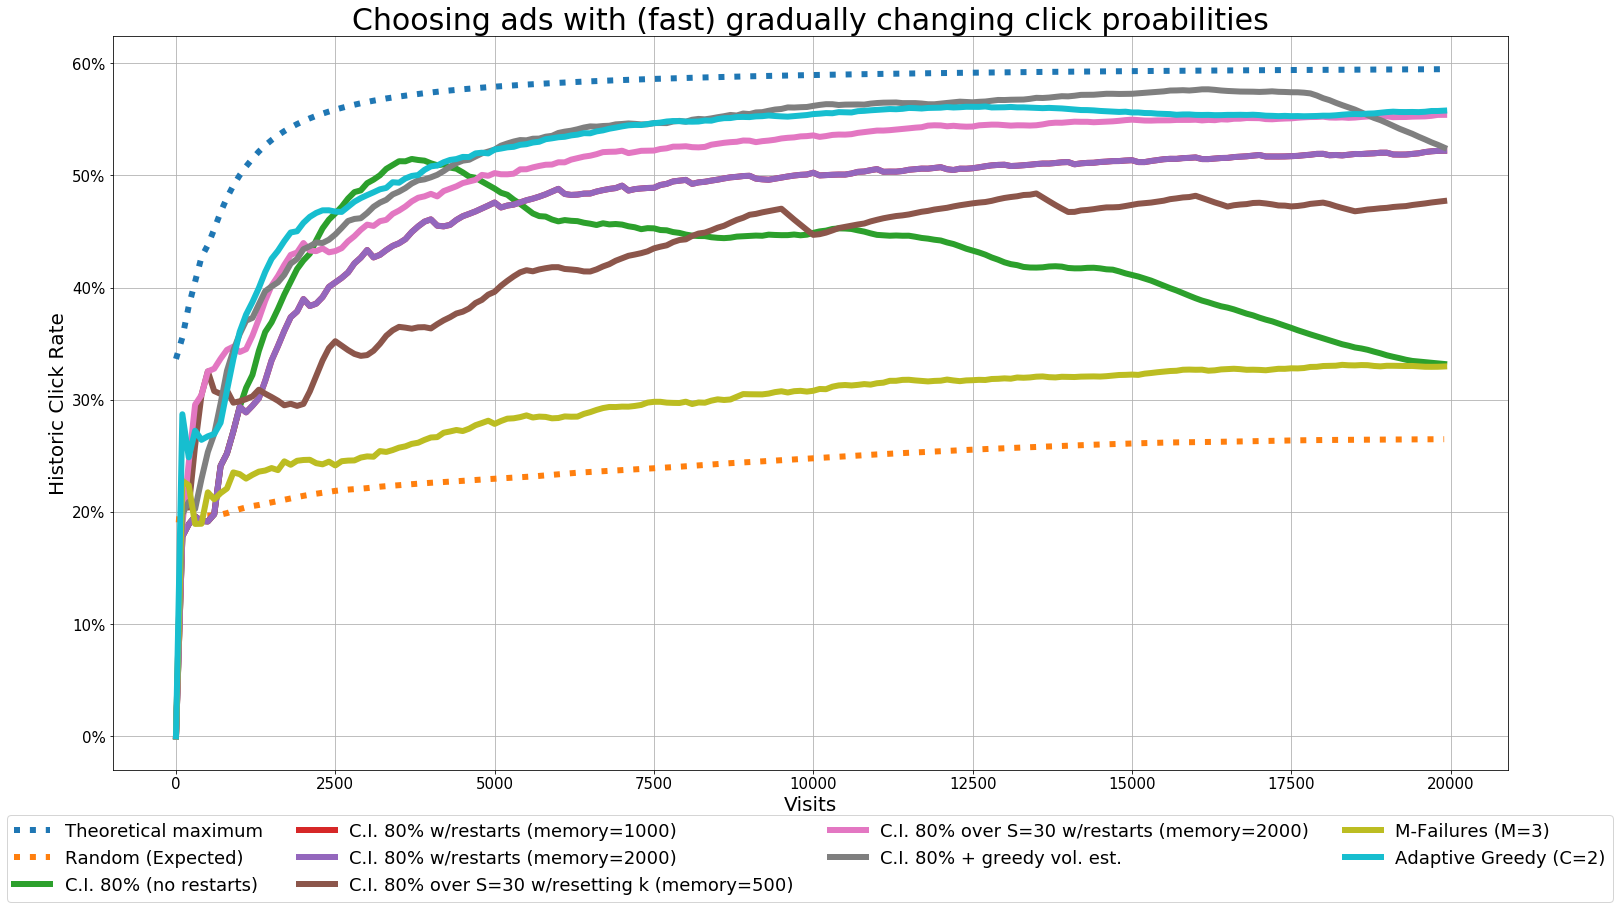

In [10]:
np.random.seed(8478)

# generating parameters
n_ads=100
ads_probscores=-3.0+np.random.normal(loc=0,scale=2,size=n_ads)
ads_volatility=np.random.gamma(2,scale=.05,size=n_ads)

# models
ci_w_restarts=restless_bandit_model(n_ads)
ctr_ci_w_restarts=list()

ci_w_restarts2=restless_bandit_model(n_ads)
ctr_ci_w_restarts2=list()

ci_no_restart=restless_bandit_model(n_ads)
ctr_ci_no_restart=list()

ci_plus_extravar=restless_bandit_model(n_ads)
ci_plus_extravar.est_volatility=0.0005
ctr_ci_plus_extravar=list()

ci_over_k=restless_bandit_model(n_ads)
ci_over_k.choose_k(30)
ctr_ci_over_k=list()

ci_over_k_w_restarts=restless_bandit_model(n_ads)
ci_over_k_w_restarts.choose_k(30)
ctr_ci_over_k_w_restarts=list()

m_failures=restless_bandit_model(n_ads)
m_failures.m=4
ctr_m_failures=list()

adaptive_greedy=restless_bandit_model(n_ads)
ctr_adaptive_greedy=list()


prob_max=list()
prob_avg=list()
ctr_max=list()
ctr_avg=list()

for t in range(20000):
    would_have_clicked=get_who_would_click()
    prob_max.append(np.max(ads_clickprob))
    prob_avg.append(np.mean(ads_clickprob))
    #############################
    
    ci_w_restarts.show_best_by_ci(would_have_clicked,t)
    ci_w_restarts2.show_best_by_ci(would_have_clicked,t)
    ci_no_restart.show_best_by_ci(would_have_clicked,t)
    ci_plus_extravar.show_best_by_ci_plus_extravar(would_have_clicked,t)
    ci_over_k.show_best_by_ci_within_k(would_have_clicked,t)
    ci_over_k_w_restarts.show_best_by_ci_within_k(would_have_clicked,t)
    m_failures.show_ad_m_failures_in_a_row(would_have_clicked,t)
    adaptive_greedy.show_ad_adaptive_greedy(would_have_clicked,t)
    
    if (t%500)==0 and t>0:
        ci_over_k.choose_k(30)
    
    if (t%1000)==0 and t>0:
        ci_w_restarts.reset()
        ci_over_k_w_restarts.reset()
        ci_over_k_w_restarts.choose_k(30)
        ci_w_restarts2.reset()
    
    #############################
    if (t%100)==0:
        ctr_max.append(np.mean(prob_max))
        ctr_avg.append(np.mean(prob_avg))

        ctr_ci_w_restarts.append(ci_w_restarts.get_ctr())
        ctr_ci_w_restarts2.append(ci_w_restarts2.get_ctr())
        ctr_ci_no_restart.append(ci_no_restart.get_ctr())
        ctr_ci_plus_extravar.append(ci_plus_extravar.get_ctr())
        ctr_ci_over_k.append(ci_over_k.get_ctr())
        ctr_ci_over_k_w_restarts.append(ci_over_k_w_restarts.get_ctr())
        ctr_m_failures.append(m_failures.get_ctr())
        ctr_adaptive_greedy.append(adaptive_greedy.get_ctr())
        
from pylab import rcParams

rcParams['figure.figsize'] = 25, 15

start_from=0
lwd=6
plt.plot(ctr_max[start_from:],label='Theoretical maximum',linestyle=':',linewidth=lwd)
plt.plot(ctr_avg[start_from:],label='Random (Expected)',linestyle=':',linewidth=lwd)

plt.plot(ctr_ci_no_restart[start_from:],label='C.I. 80% (no restarts)',linewidth=lwd)
plt.plot(ctr_ci_w_restarts[start_from:],label='C.I. 80% w/restarts (memory=1000)',linewidth=lwd)
plt.plot(ctr_ci_w_restarts2[start_from:],label='C.I. 80% w/restarts (memory=2000)',linewidth=lwd)
plt.plot(ctr_ci_over_k[start_from:],label='C.I. 80% over S=30 w/resetting k (memory=500)',linewidth=lwd)
plt.plot(ctr_ci_over_k_w_restarts[start_from:],label='C.I. 80% over S=30 w/restarts (memory=2000)',linewidth=lwd)
plt.plot(ctr_ci_plus_extravar[start_from:],label='C.I. 80% + greedy vol. est.',linewidth=lwd)
plt.plot(ctr_m_failures[start_from:],label='M-Failures (M=3)',linewidth=lwd)
plt.plot(ctr_adaptive_greedy[start_from:],label='Adaptive Greedy (C=2)',linewidth=lwd)
plt.grid()

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=4, prop={'size':18})

plt.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels([0]+[100*i for i in range(0,225,25)])

ax.yaxis.set_ticks([i/10 for i in range(0,int(10*np.round(np.max(ads_clickprob),1))+1)])
ax.yaxis.set_ticklabels([str(i*10)+'%' for i in range(0,int(10*np.round(np.max(ads_clickprob),1))+1)])

plt.xlabel('Visits',size=20)
plt.ylabel('Historic Click Rate',size=20)
plt.title('Choosing ads with (fast) gradually changing click proabilities',size=30)
plt.show()

<a id="p4"></a>
## 4. Expiring ads (mortal multi-armed bandits)
** *
Finally, another interesting and realistic variation is considering the case of ads that can expire or die - either thorugh some random process or through some limited budget allocation. This problem is studied in [Chakrabarti, D., Kumar, R., Radlinski, F., & Upfal, E. (2009). Mortal multi-armed bandits. In Advances in neural information processing systems (pp. 273-280).](http://papers.nips.cc/paper/3580-mortal-multi-armed-bandits)

If the distribution of the click probabilties and the expected lifetimes of ads are known, then as described in the paper, the optimal exploration-exploitation balance can be determined with:

$$ \Gamma(\mu) = \frac{E[X] + (1-F(\mu))(L-1)E[X|X \ge \mu]}{1+(1-F(\mu))(L-1)}  $$

where $X$ denotes the click probabilities of ads, $F(\mu)$ is the cummulative distribution from which these click probabilities generate, and $L$ is the expected lifetime of an ad.

Their propossed _Stochastic_ algorithm starts by probing ads one at a time for $n$ steps. If, after those $n$ steps, an ad's empirical click probability is greater than $n \times \mu^*$ (with $\mu^* = argmax \, \Gamma(\mu)$), then that ad is played until it dies, otherwise a new ad is explored, and if $n=O(log\,L/\epsilon^2)$, its expected reward on exploitation steps is $\Gamma(\mu^*-\epsilon)$.

However, this still requires knowing the cummulative distribution of click probabilites and the expected lifetimes. These can, nevertheless, be estimated and the estimations updated periodically according to observed clicks and impressions, using Bayesian methods (similar to Thompson sampling, the estimated ad probabilities being sampled from some beta distribution, using small priors given by the average click rate of all ads).

Here I'll also compare this cannonical _Stochastic_ algorithm with other algorithms described in the same paper, plus variations of the algorithms that estimate the environment's parameters dynamically (note that _stochastic with early stop_ is biased towards sampling a larger number of low-performing ads, thus it needs some adjustment), and some algorithms for the many-armed bandits problem.

I'll also make the simulation a bit different from what was described in the paper, in the sense that the pool of available ads can vary in size - the ads dying randomly with a certain probability at each turn, and new ads spawning with a certain probability at each turn. The expected value of the size of the pool of ads to choose will still be constant though.
** *
Functions related to the gamma function described above (assuming the click probabilities of ads follow a beta distribution):

In [11]:
from mpmath import gamma, quad # --> this is to calculate defined integrals
from scipy.stats import beta

def beta_func(a,b):
    return gamma(a)*gamma(b)/gamma(a+b)

def beta_pdf(x,a,b):
    return (x**(a-1))*((1-x)**(b-1))/beta_func(a,b)

def exp_beta_cond(u,a,b):
    f=lambda x: x*beta_pdf(x,a,b)
    div=lambda x: beta_pdf(x,a,b)
    return float(quad(f,(u,1))/quad(div,(u,1)))

def G(u,a,b,L):
    num=(a/(a+b))+(1-beta.cdf(u,a,b))*(L-1)*exp_beta_cond(u,a,b)
    denom=1+(1-beta.cdf(u,a,b))*(L-1)
    return num/denom

def argmax_G(a,b,L):
    rng=np.linspace(0,1,100,endpoint=False)
    return rng[np.argmax([G(x,a,b,L) for x in rng])]

def get_n(L,e=.1,const=.8):
    return int(np.around(const*np.log(L/(e**2)),0))

def get_L(dead_arms_lifetimes):
    return np.mean(dead_arms_lifetimes)

Note that, in this case, any algorithm that remembers some ads from the past needs to update their indices every time some ad dies:

In [12]:
def reindex_ad(index_before):
    global die_round
    if len(die_round)==1:
        if index_before<die_round[0]:
            return index_before
        else:
            return index_before-1
    else:
        dead_now=np.array(die_round)
        min_dead=np.min(dead_now)
        max_dead=np.max(dead_now)
        if index_before<min_dead:
            return index_before
        elif index_before>max_dead:
            return index_before-dead_now.shape[0]
        else:
            index_after={i:i-np.sum(dead_now<=i) for i in range(min_dead+1,max_dead)}
            return index_after[index_before]
        
def mapix(ix,min_dead,max_dead,index_after,n_dead):
    if ix<min_dead:
        return ix
    if ix>max_dead:
        return ix-n_dead
    return index_after[ix]

Creating the classes necessary for the simulation - again, despite having the same names as before, the methods are quite different.

Note that, for ads that died before having been tried, it's not necessary to remember anything other than the time they survivied, but for ads that were shown before dying, algorithms that estimate the environment's parameters dynamically still need to remember their particular clicks and impressions.

_Warning: long code_

In [13]:
class dead_ads_pool:
    def __init__(self):
        self.clicks=list()
        self.displays=list()
        self.total_clicks=0
        self.total_displays=0
    
    def get_total_ctr(self):
        return self.total_clicks/self.total_displays
    
    def get_total_clicks(self):
        return self.total_clicks
    
    def get_total_displays(self):
        return self.total_displays
    
    # this is to estimate the environment's parameters as described at the beginning
    def sample_beta_parameters(self,p_add):
        return [np.random.beta(self.clicks[ad]+p_add,self.displays[ad]-self.clicks[ad]+1) for ad in range(len(self.clicks))]
    
    def add_new(self,ad_clicks,ad_displays):
        self.total_clicks+=ad_clicks
        self.total_displays+=ad_displays
        if ad_displays>0:
            self.clicks.append(ad_clicks)
            self.displays.append(ad_displays)
            
class bandit_model:
    def __init__(self):
        self.clicks=np.array([],dtype='int32')
        self.displays=np.array([],dtype='int32')
        self.dead_ads=dead_ads_pool()
        
        self.u_star=.5
        self.n=10
        self.d=0
        self.exploit=False
        self.can_get_fresh_random=True
        self.rand=0
        self.last_dead=set()
        
        self.k_chosen=None
        self.k=0
        
        self.greedy_c=2.5
        
        self.m=4
        self.first_nontried=0
        self.failures_in_a_row=0
        
    def add_new(self,number):
        if number>0:
            self.clicks=np.concatenate([self.clicks,[0]*number])
            self.displays=np.concatenate([self.displays,[0]*number])
    
    def remove(self,remove_set):
        self.last_dead=remove_set
        for ad in remove_set:
            self.dead_ads.add_new(self.clicks[ad],self.displays[ad])
        self.clicks=np.array([self.clicks[i] for i in range(self.clicks.shape[0]) if i not in remove_set])
        self.displays=np.array([self.displays[i] for i in range(self.displays.shape[0]) if i not in remove_set])
        
    def show_ad(self,selected_ad,would_have_clicked):
        self.displays[selected_ad]+=1
        self.clicks[selected_ad]+=would_have_clicked[selected_ad]
        
    def get_ctr(self):
        return (np.sum(self.clicks)+self.dead_ads.get_total_clicks())/(np.sum(self.displays)+self.dead_ads.get_total_displays())
        
    def get_best_r(self):
        return np.nanmax(self.clicks/self.displays)
    
    def show_best_ad(self,would_have_clicked):
        best=np.nanargmax(self.clicks/self.displays)
        self.show_ad(best,would_have_clicked)
        
    def show_random_ad(self,would_have_clicked):
        self.show_ad(np.random.randint(low=0,high=self.clicks.shape[0]),would_have_clicked)
        
    def determine_new_random(self):
        if np.sum(self.displays==0)>0:
            self.rand=np.random.choice([i for i in range(self.displays.shape[0]) if self.displays[i]==0])
            return True
        else:
            return False
        
    def show_last_random(self,would_have_clicked,need_reindex=True):
        if (len(self.last_dead)>0) and need_reindex:
            self.rand=reindex_ad(self.rand)
        self.show_ad(self.rand,would_have_clicked)
        self.d+=1
    
    def sample_beta_parameters(self,mult_p=1):
        p_add=self.get_ctr()*mult_p
        sample_alive=[np.random.beta(self.clicks[ad]+p_add,self.displays[ad]-self.clicks[ad]+1) for ad in range(len(self.clicks)) if self.displays[ad]>0]
        sample_dead=self.dead_ads.sample_beta_parameters(p_add)
        return sample_alive+sample_dead
    
    def update_parameter_estimates(self,L,e,const,mult_p):
        self.n=get_n(L,e,const)
        betafit=beta.fit(self.sample_beta_parameters(mult_p))
        self.u_star=argmax_G(betafit[0],betafit[1],L)
        
    def get_true_parameters(self,generator_par_L,generator_par_a,generator_par_b,e,const=1):
        self.n=get_n(generator_par_L,e,const)
        self.u_star=argmax_G(generator_par_a,generator_par_b,generator_par_L)
        
    def get_n(self):
        return self.n
    
    def get_u_star(self):
        return self.u_star
    
    def show_best_thompson(self,would_have_clicked):
        if np.sum(self.displays)==0:
            self.show_ad(np.random.randint(low=0,high=len(would_have_clicked)),would_have_clicked)
        else:
            ad_thompson=np.argmax([np.random.beta(self.clicks[ad]+1,self.displays[ad]-self.clicks[ad]+1) for ad in range(len(self.clicks))])
            self.show_ad(ad_thompson,would_have_clicked)
        
    def show_best_by_ci(self,would_have_clicked):
        rates=self.clicks/self.displays
        ad_ci=np.argmax(rates+0.8*np.sqrt(rates*(1-rates)/self.displays))
        self.show_ad(ad_ci,would_have_clicked)
        
    def choose_k(self,k):
        self.k_chosen=set(np.random.choice([i for i in range(self.clicks.shape[0])],size=k,replace=False))
        self.k=k
        
    def update_indices_k(self,die_round):
        if len(die_round)==0:
            return None
        k_new=[i for i in self.k_chosen if i not in die_round]
        if len(k_new)<=(self.k/2):
            self.choose_k(self.k)
        else:
            if len(die_round)==1:
                self.k_chosen=set([i if i<die_round[0] else i-1 for i in k_new])
            else:
                dead_now=np.array(die_round)
                min_dead=np.min(dead_now)
                max_dead=np.max(dead_now)
                n_dead=dead_now.shape[0]
                index_after={i:i-np.sum(dead_now<=i) for i in range(min_dead+1,max_dead)}
                self.k_chosen=set([mapix(ix,min_dead,max_dead,index_after,n_dead) for ix in k_new])
            
    def show_best_thompson_within_k(self,would_have_clicked):
        ad_thompson=np.argmax([np.random.beta(self.clicks[ad]+1,self.displays[ad]-self.clicks[ad]+1) if ad in self.k_chosen else -1.0 for ad in range(len(self.clicks))])
        self.show_ad(ad_thompson,would_have_clicked)
        
    def show_best_by_ci_within_k(self,would_have_clicked):      
        rates=self.clicks/self.displays
        ci=rates+0.8*np.sqrt(rates*(1-rates)/self.displays)
        ci[[i for i in range(self.clicks.shape[0]) if i not in self.k_chosen]]=-1
        self.show_ad(np.argmax(ci),would_have_clicked)
        
    def show_ad_adaptive_greedy(self,would_have_clicked):
        if np.sum(self.clicks)==0:
            self.show_random_ad(would_have_clicked)
        else:
            bestr=self.get_best_r()
            if np.random.random()<self.greedy_c*bestr:
                self.show_best_ad(would_have_clicked)
            else:
                self.show_random_ad(would_have_clicked)
                
    def show_ad_adaptive_greedy_split_newold(self,would_have_clicked,p_new=.35):
        if np.sum(self.clicks)==0:
            self.show_random_ad(would_have_clicked)
        else:
            bestr=self.get_best_r()
            if np.random.random()<self.greedy_c*bestr:
                self.show_best_ad(would_have_clicked)
            else:
                if np.random.random()<p_new:
                    # choose a new random ad
                    if np.sum(self.displays==0)>0:
                        random_ad=np.random.choice([i for i in range(self.displays.shape[0]) if self.displays[i]==0])
                        self.show_ad(random_ad,would_have_clicked)
                    else:
                        self.show_random_ad(would_have_clicked)
                else:
                    # choose an old random ad
                    if np.sum(self.displays>0)>0:
                        random_ad=np.random.choice([i for i in range(self.displays.shape[0]) if self.displays[i]>0])
                        self.show_ad(random_ad,would_have_clicked)
                    else:
                        self.show_random_ad(would_have_clicked)
    
    def set_greedy_c(self,c):
        self.greedy_c=c
        
    def select_and_show_new_ad(self,would_have_clicked):
        self.exploit=False
        self.d=0
        self.can_get_fresh_random=self.determine_new_random()
        if self.can_get_fresh_random:
            self.show_ad(self.rand,would_have_clicked)
            self.d+=1
        else:
            self.show_best_by_ci(would_have_clicked)
        
    def show_ad_stochastic(self,would_have_clicked):
        if self.exploit:
            if self.rand in self.last_dead:
                self.select_and_show_new_ad(would_have_clicked)
            else:
                if len(self.last_dead)>0:
                    self.rand=reindex_ad(self.rand)
                if self.clicks[self.rand]>(self.n*self.u_star):
                    self.show_last_random(would_have_clicked,need_reindex=False)
                    self.exploit=True
                else:
                    self.select_and_show_new_ad(would_have_clicked)
        else:
            # keep exploring last random arm
            if self.can_get_fresh_random and (self.rand not in self.last_dead):
                self.show_last_random(would_have_clicked)
                if self.d>=self.n:
                    self.exploit=True
            else:
                self.select_and_show_new_ad(would_have_clicked)
                
    def show_ad_stochastic_w_early_stop(self,would_have_clicked):
        if self.exploit:
            if self.rand in self.last_dead:
                self.select_and_show_new_ad(would_have_clicked)
            else:
                if len(self.last_dead)>0:
                    self.rand=reindex_ad(self.rand)
                if self.clicks[self.rand]>(self.n*self.u_star):
                    self.show_last_random(would_have_clicked,need_reindex=False)
                    self.exploit=True
                else:
                    self.select_and_show_new_ad(would_have_clicked)
        else:
            # keep exploring last random arm
            if self.can_get_fresh_random and (self.rand not in self.last_dead):
                if len(self.last_dead)>0:
                    self.rand=reindex_ad(self.rand)
                if (self.n-self.d+1)>=(self.n*self.u_star-self.clicks[self.rand]):
                    self.show_last_random(would_have_clicked,need_reindex=False)
                    if self.d>=self.n:
                        self.exploit=True
                else:
                    self.select_and_show_new_ad(would_have_clicked)
            else:
                self.select_and_show_new_ad(would_have_clicked)
                
    def set_m(self,m):
        self.m=m
        
    def get_first_untried(self):
        self.failures_in_a_row=0
        nontried=np.where(self.displays==0)
        if nontried[0].shape[0]>0:
            self.first_nontried=np.min(nontried[0])
        else:
            self.first_nontried=None
            
    def show_ad_m_failures(self,would_have_clicked):
        if self.first_nontried is None:
            self.get_first_untried()
        if self.first_nontried is None:
            self.show_best_by_ci(would_have_clicked)
        else:
            if len(self.last_dead)>0 and (self.first_nontried not in self.last_dead):
                self.first_nontried=reindex_ad(self.first_nontried)
            if self.first_nontried in self.last_dead:
                self.get_first_untried()
            if (self.displays[self.first_nontried]-self.clicks[self.first_nontried])>=self.m:
                self.get_first_untried()
            if self.first_nontried is None:
                self.show_best_by_ci(would_have_clicked)
            else:
                self.show_ad(self.first_nontried,would_have_clicked)
        
    def show_ad_m_failures_in_a_row(self,would_have_clicked):
        if self.first_nontried is None:
            self.get_first_untried()
        if self.first_nontried is None:
            self.show_best_by_ci(would_have_clicked)
        else:
            if (self.failures_in_a_row>=self.m) or (self.first_nontried in self.last_dead):
                self.get_first_untried()
                if self.first_nontried is None:
                    self.show_best_by_ci(would_have_clicked)
                else:
                    self.show_ad(self.first_nontried,would_have_clicked)
                    self.failures_in_a_row+=1-would_have_clicked[self.first_nontried]
            ####################
            else:
                if len(self.last_dead)>0:
                    self.first_nontried=reindex_ad(self.first_nontried)
                self.show_ad(self.first_nontried,would_have_clicked)
                self.failures_in_a_row+=1-would_have_clicked[self.first_nontried]
                
    def update_indices_k_fixed(self,die_round):
        if len(die_round)==0:
            return None
        k_new=[i for i in self.k_chosen if i not in self.last_dead]
        if len(k_new)<self.k:
            dead_now=np.array(die_round)
            min_dead=np.min(dead_now)
            max_dead=np.max(dead_now)
            n_dead=dead_now.shape[0]
            index_after={i:i-np.sum(dead_now<=i) for i in range(min_dead+1,max_dead)}
            k_new=[mapix(ix,min_dead,max_dead,index_after,n_dead) for ix in k_new]
            k_new+=list(np.random.choice([i for i in range(self.displays.shape[0]) if i not in set(k_new)],
                                                size=self.k-len(k_new),replace=False))
            self.k_chosen=set(k_new)

Finally, defining the environment and the processes related to ads:

In [14]:
# simulation's underlying parameters
generator_par_a=2
generator_par_b=10

# modeling mortality
generator_par_L=200
generator_par_p=1/generator_par_L

# initial parameter estimates set at random
np.random.seed(123)
L=np.random.uniform(50,500)

# initial 100 arms
n_ads=100
ads_clickprob=list(np.random.beta(generator_par_a,generator_par_b,size=n_ads))

# useful data structures and functions
life_ads=np.array([0 for i in range(n_ads)])
dead_arms_life=list()

def increase_life_counter():
    global life_ads
    life_ads+=1

def death_process():
    global life_ads,ads_clickprob,dead_arms_life
    
    die=np.random.binomial(1,generator_par_p,size=len(ads_clickprob))
    list_dead=np.where(die==1)[0]
    if list_dead.shape[0]>0:
        dead_arms_life+=[life_ads[ad] for ad in list_dead]
        ads_clickprob=[ads_clickprob[i] for i in range(len(ads_clickprob)) if i not in list_dead]
        life_ads=life_ads[np.where(die==0)[0]]
    return list_dead.tolist()


def spawn_process():
    global life_ads,ads_clickprob, spawn_number
    
    spawn_number=np.random.binomial(n_ads,generator_par_p)
    if spawn_number>0:
        life_ads=np.concatenate([life_ads,[0]*spawn_number])
        ads_clickprob+=list(np.random.beta(generator_par_a,generator_par_b,size=spawn_number))
    return spawn_number

def get_who_would_click():
    global ads_clickprob
    
    return [np.random.binomial(1,clickprob) for clickprob in ads_clickprob]

In [15]:
bandits_thompson=bandit_model()
bandits_thompson.add_new(n_ads)
ctr_thomp=list()

bandits_thompson_k=bandit_model()
bandits_thompson_k.add_new(n_ads)
bandits_thompson_k.choose_k(20)
ctr_thompson_k=list()

bandits_ci=bandit_model()
bandits_ci.add_new(n_ads)
ctr_ci=list()

bandits_ci_k=bandit_model()
bandits_ci_k.add_new(n_ads)
bandits_ci_k.choose_k(20)
ctr_ci_k=list()

bandits_ci_k_fixed=bandit_model()
bandits_ci_k_fixed.add_new(n_ads)
bandits_ci_k_fixed.choose_k(25)
ctr_ci_k_fixed=list()

bandits_adaptive_greedy=bandit_model()
bandits_adaptive_greedy.add_new(n_ads)
ctr_adaptive_greedy=list()

bandits_stochastic=bandit_model()
bandits_stochastic.add_new(n_ads)
bandits_stochastic.get_true_parameters(generator_par_L,generator_par_a,generator_par_b,e=.1,const=.8)
ctr_stochastic=list()

bandits_stochastic_est_parameters=bandit_model()
bandits_stochastic_est_parameters.add_new(n_ads)
ctr_stochastic_est_params=list()

bandits_stochastic_w_early_stop=bandit_model()
bandits_stochastic_w_early_stop.add_new(n_ads)
bandits_stochastic_w_early_stop.get_true_parameters(generator_par_L,generator_par_a,generator_par_b,e=.1,const=.8)
ctr_stochastic_w_early_stop=list()

bandits_stochastic_w_early_stop_est_par=bandit_model()
bandits_stochastic_w_early_stop_est_par.add_new(n_ads)
ctr_stochastic_w_early_stop_est_par=list()

bandits_m_failures=bandit_model()
bandits_m_failures.add_new(n_ads)
bandits_m_failures.set_m(7)
ctr_m_failures=list()

bandits_m_failures_in_a_row=bandit_model()
bandits_m_failures_in_a_row.add_new(n_ads)
bandits_m_failures_in_a_row.set_m(5)
ctr_m_failures_in_a_row=list()

bandit_models=[bandits_thompson,bandits_thompson_k,bandits_ci,bandits_ci_k,bandits_ci_k_fixed,
               bandits_adaptive_greedy,bandits_stochastic,bandits_stochastic_est_parameters,
               bandits_stochastic_w_early_stop,bandits_stochastic_w_early_stop_est_par,
               bandits_m_failures,bandits_m_failures_in_a_row]


r_max=list()
r_random=list()
ctr_max=list()
ctr_random_exp=list()

np.random.seed(1595)
for i in range(20000):
    increase_life_counter()
    would_have_clicked=get_who_would_click()
    
    r_random.append(np.mean(ads_clickprob))
    r_max.append(np.max(ads_clickprob))
    
    ######################
    bandits_thompson.show_best_thompson(would_have_clicked)
    bandits_thompson_k.show_best_thompson_within_k(would_have_clicked)
    bandits_ci.show_best_by_ci(would_have_clicked)
    bandits_ci_k.show_best_by_ci_within_k(would_have_clicked)
    bandits_ci_k_fixed.show_best_by_ci_within_k(would_have_clicked)
    bandits_adaptive_greedy.show_ad_adaptive_greedy(would_have_clicked)
    bandits_stochastic.show_ad_stochastic(would_have_clicked)
    bandits_stochastic_est_parameters.show_ad_stochastic(would_have_clicked)
    bandits_stochastic_w_early_stop.show_ad_stochastic_w_early_stop(would_have_clicked)
    bandits_stochastic_w_early_stop_est_par.show_ad_stochastic_w_early_stop(would_have_clicked)
    bandits_m_failures.show_ad_m_failures(would_have_clicked)
    bandits_m_failures_in_a_row.show_ad_m_failures_in_a_row(would_have_clicked)
    
    if ((i%1000)==0) and (i>0):
        bandits_stochastic_est_parameters.update_parameter_estimates(get_L(dead_arms_life),e=.1,const=.8,mult_p=1)
        bandits_stochastic_w_early_stop_est_par.update_parameter_estimates(get_L(dead_arms_life),e=.1,const=.8,mult_p=2)
    ######################
    die_round=death_process()
    die_set=set(die_round)
    for bandit in bandit_models:
        bandit.remove(die_set)
    
    new_ads=spawn_process()
    for bandit in bandit_models:
        bandit.add_new(new_ads)
    bandits_thompson_k.update_indices_k(die_round)
    bandits_ci_k.update_indices_k(die_round)
    bandits_ci_k_fixed.update_indices_k_fixed(die_round)
    
    ######################
    if (i%100)==0:
        ctr_random_exp.append(np.mean(r_random))
        ctr_max.append(np.mean(r_max))
        ctr_thomp.append(bandits_thompson.get_ctr())
        ctr_thompson_k.append(bandits_thompson_k.get_ctr())
        ctr_ci.append(bandits_ci.get_ctr())
        ctr_ci_k.append(bandits_ci_k.get_ctr())
        ctr_ci_k_fixed.append(bandits_ci_k_fixed.get_ctr())
        ctr_adaptive_greedy.append(bandits_adaptive_greedy.get_ctr())
        ctr_stochastic.append(bandits_stochastic.get_ctr())
        ctr_stochastic_est_params.append(bandits_stochastic_est_parameters.get_ctr())
        ctr_stochastic_w_early_stop.append(bandits_stochastic_w_early_stop.get_ctr())
        ctr_stochastic_w_early_stop_est_par.append(bandits_stochastic_w_early_stop_est_par.get_ctr())
        ctr_m_failures.append(bandits_m_failures.get_ctr())
        ctr_m_failures_in_a_row.append(bandits_m_failures_in_a_row.get_ctr())
        

C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:122: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:152: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:71: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\ipykernel\__main__.py:74: RuntimeWarning: invalid value encountered in true_divide
C:\Users\david\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\david\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


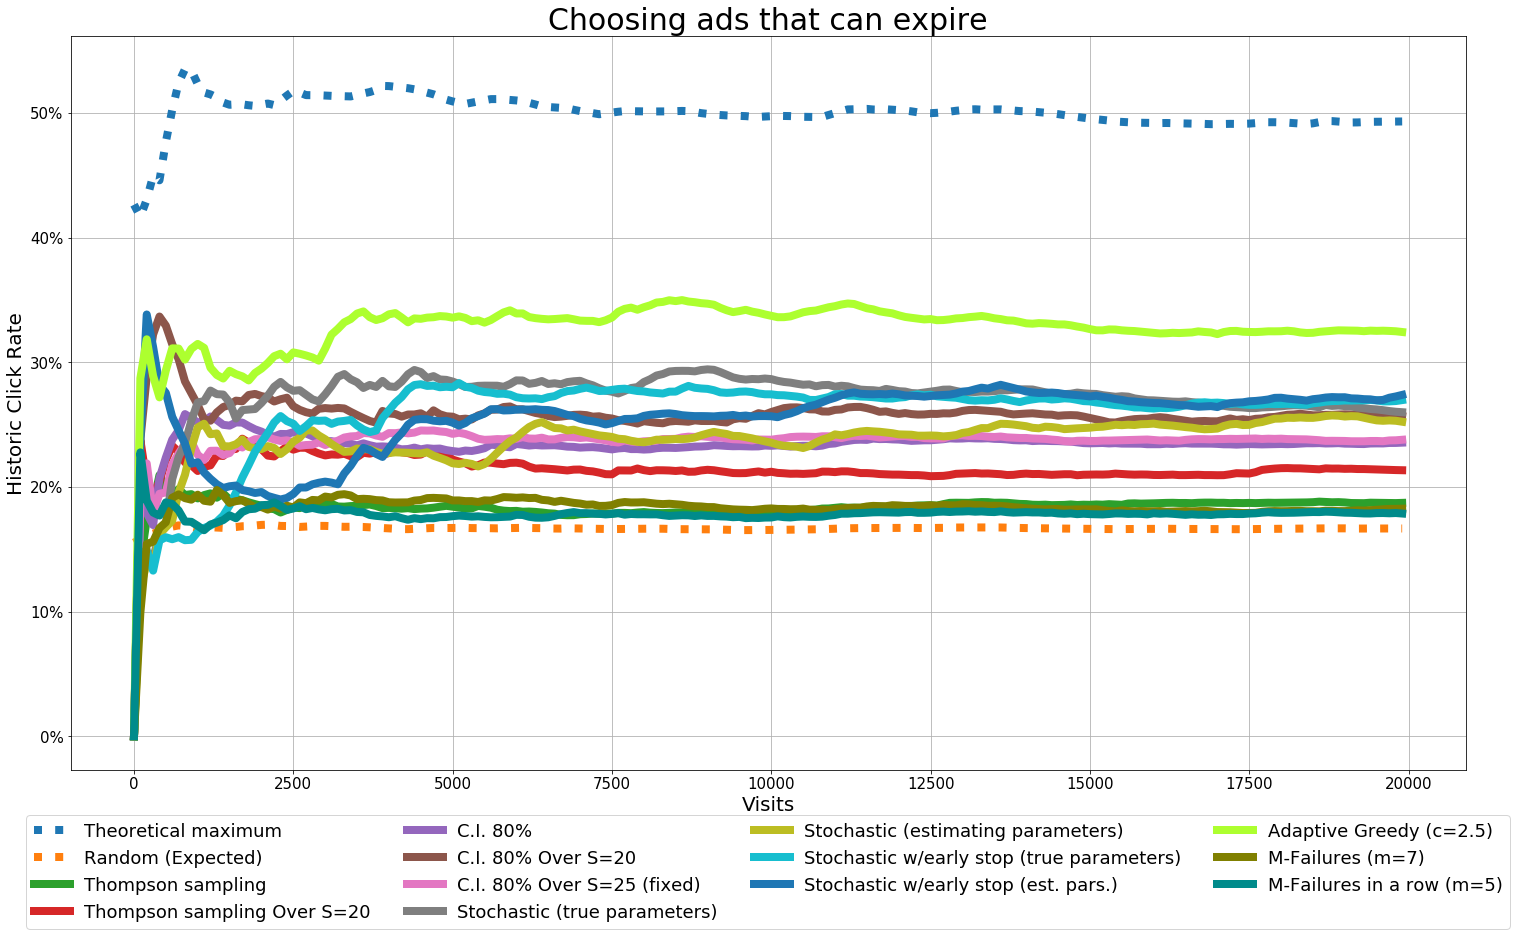

In [16]:
rcParams['figure.figsize'] = 25, 15

start_from=0
lwd=8
plt.plot(ctr_max[start_from:],label='Theoretical maximum',linestyle=':',linewidth=lwd)
plt.plot(ctr_random_exp[start_from:],label='Random (Expected)',linestyle=':',linewidth=lwd)
plt.plot(ctr_thomp[start_from:],label='Thompson sampling',linewidth=lwd)
plt.plot(ctr_thompson_k[start_from:],label='Thompson sampling Over S=20',linewidth=lwd)
plt.plot(ctr_ci[start_from:],label='C.I. 80%',linewidth=lwd)
plt.plot(ctr_ci_k[start_from:],label='C.I. 80% Over S=20',linewidth=lwd)
plt.plot(ctr_ci_k_fixed[start_from:],label='C.I. 80% Over S=25 (fixed)',linewidth=lwd)
plt.plot(ctr_stochastic[start_from:],label='Stochastic (true parameters)',linewidth=lwd)
plt.plot(ctr_stochastic_est_params[start_from:],label='Stochastic (estimating parameters)',linewidth=lwd)
plt.plot(ctr_stochastic_w_early_stop[start_from:],label='Stochastic w/early stop (true parameters)',linewidth=lwd)
plt.plot(ctr_stochastic_w_early_stop_est_par[start_from:],label='Stochastic w/early stop (est. pars.)',linewidth=lwd)
plt.plot(ctr_adaptive_greedy[start_from:],label='Adaptive Greedy (c=2.5)',linewidth=lwd, color='greenyellow')
plt.plot(ctr_m_failures[start_from:],label='M-Failures (m=7)',linewidth=lwd,color='olive')
plt.plot(ctr_m_failures_in_a_row[start_from:],label='M-Failures in a row (m=5)',linewidth=lwd,color='darkcyan')
plt.grid()

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=4, prop={'size':18})

plt.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels([0]+[100*i for i in range(0,225,25)])
ax.yaxis.set_ticks([0,.1,.2,.3,.4,.5])
ax.yaxis.set_ticklabels(['0%','10%','20%','30%','40%','50%'])

plt.xlabel('Visits',size=20)
plt.ylabel('Historic Click Rate',size=20)
plt.title('Choosing ads that can expire',size=30)
plt.show()

CTR that Stochastic would have, in theory, expected to get in exploitation steps:

In [17]:
G(argmax_G(generator_par_a,generator_par_b,generator_par_L)-.1, generator_par_a,generator_par_b,generator_par_L)

0.37818690323433907

If taking it further, _Stochastic_ and _Adaptive-Greedy_ would very naturally extend to the cases of infinite ads, changing reward probabilities, and unequal pay-per-click. Their performance under such a mixed situation would, however, be very sensitive on the simulation’s parameters and the parameters with which they are followed.